In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [24]:
outlier_czs = [34105, 34113, 34112, 34106]
df = (
    pd.read_csv('data/mobility.csv')
    # filter out rows with NaN AUM values
    .query('not aum.isnull()', engine='python')
    # take out outlier CZs
    .query('cz not in @outlier_czs')
)

(sec:linear_simple_fit)=
# Fitting the Simple Linear Model

After picking a model, the predictor variable(s), and the outcome variable,
we want to use our data to find the model parameters
$ \theta_0 $ and $ \theta_1 $.
This process is called *fitting a model* to data.

To fit our model, we'll use loss minimization (first introduced in
{numref}`Chapter %s <ch:modeling>`).
We'll pick a loss function, then find out which values of
$ \theta_0 $ and $ \theta_1 $ give the smallest loss for our data.
For linear models, we typically choose the squared loss.
For a given data point $ (x, y) $ and model parameters $ \theta $, the
squared loss is:

$$
\begin{aligned}
{\cal l}(\theta, x, y) = (y - f_{\theta}(x))^2
\end{aligned}
$$

This loss function says: find the difference between the
actual observed $ y $ and the prediction $ f_{\theta}(x) $, then square it.

We say that the dataset has $ n $ points: $ (x_1, y_1), \ldots, (x_n, y_n) $.
To simplify the notation, we say that the column vector
$ x = [x_1, \ldots, x_n] $ and $ y = [y_1, \ldots, y_n] $.
The mean squared loss (MSE) is the average loss for the entire dataset:

$$
\begin{aligned}
L(\theta, x, y)
 &= \frac{1}{n} \sum_{i} {\cal l}(\theta, x_i, y_i) \\
 &= \frac{1}{n} \sum_{i}(y_i - f_{\theta}(x_i))^2
\end{aligned}
$$


With our loss function defined, we can now use calculus to
find the $ \hat{\theta}_0 $ and $ \hat{\theta}_1 $ that minimize the loss.

## Minimizing the Loss

Let's derive the best fit model parameter $ \hat{\theta}_0 $.
We start by plugging in the model equation
$ f_{\theta}(x) = \theta_0 + \theta_1 x $ into the loss equation:

$$
\begin{aligned}
L(\theta, x, y)
  &= \frac{1}{n} \sum_{i}(y_i - f_{\theta}(x_i))^2 \\
  &= \frac{1}{n} \sum_{i}(y_i - \theta_1 x_i - \theta_0)^2 \\
\end{aligned}
$$

To find $ \hat{\theta}_0 $, we take the partial derivative of the loss:

$$
\begin{aligned}
\frac{\partial}{\partial \theta_0} L(\theta, x, y)
  &= \frac{1}{n} \sum_{i} 2 (y_i - \theta_1 x_i - \theta_0) (-1)
\end{aligned}
$$

Then, we set the partial derivative equal to 0 and solve for
$ \hat{\theta}_0 $:

$$
\begin{aligned}
\frac{1}{n} \sum_{i}
  2 (y_i - \hat{\theta}_1 x_i - \hat{\theta}_0) (-1) &= 0 \\
\sum_{i} (\hat{\theta}_0 + \hat{\theta}_1 x_i - y_i) &= 0 \\
n \hat{\theta}_0 + \hat{\theta}_1 \textstyle \sum x_i
  - \textstyle \sum y_i &= 0 \\
\hat{\theta}_0 &= 
  \textstyle \frac{1}{n} \sum y_i - 
  \hat{\theta}_1 \frac{1}{n} \textstyle \sum x_i \\
\end{aligned}
$$

Using the shorthand $ \bar x = \sum x_i $,
the final expression for $ \hat{\theta}_0 $ can be simplified to:

$$
\begin{aligned}
\hat{\theta}_0 &= \bar y - \hat{\theta}_1 \bar x
\end{aligned}
$$

Here we run into a complication:
$ \hat{\theta}_0 $ depends on $ \hat{\theta}_1 $.
To solve this, we can start solving for $ \hat{\theta}_1 $ by 
taking the derivative of $ L(\theta, x, y) $ with respect to
$ \theta_1 $.
If we do this, we'll find that the formula for $ \hat{\theta}_1 $ depends on
$ \hat{\theta}_0 $, so we can plug in
$ \hat{\theta}_0 = \bar y - \hat{\theta}_1 \bar x $ and solve.
The algebra is long, so we'll leave this the derivation as an exercise.
After the derivation, the resulting $ \hat{\theta}_1 $ is:

$$
\begin{aligned}
\hat{\theta}_1 &= r \frac{\sigma_y}{\sigma_x}
\end{aligned}
$$

In the formula above, $ \sigma_x $ and $ \sigma_y $ are the standard deviations
of $ x $ and $ y $.
The correlation coefficient $ r $ is
the average of the products of $ x $ and $ y $ in standard units
(subtracting the mean, then dividing by the standard deviation).
Since `pandas.Series` objects have built-in methods to compute
$ \sigma_x $,  $ \sigma_y $, and $ r $,
we can quickly define functions that fit the model
to our data:

In [26]:
def theta_1(x, y):
    r = x.corr(y)
    return r * y.std() / x.std()

In [27]:
def theta_0(x, y):
    return y.mean() - theta_1(x, y) * x.mean()

## Example: What's the Relationship Between Commute Time and Upward Mobility?

Now, let's fit a simple linear model on the economic mobility data.
Once we do this, we can look at the relationship between commute time and
upward mobility.

When modeling, we first split our dataset into a training set
and a test set.
We fit our model using only the data in the training set.
Then, we report our model's accuracy using only the test set.

:::{note}

Why do we need to separate the training set and the test set?
There are deep statistical reasons for splitting up the data, but 
rigorously showing this requires more space than we have.
Instead, we'll try to give intuition using an analogy.
Let's say your friend Jan is studying for a math exam.
To "train", he reviews the examples from the class's lecture slides.
To check how well Jan knows the material, we wouldn't want to 
reuse the lecture examples for the exam---since he specifically
reviewed those examples, he'd do unfairly well.
Instead, we'd write new "test" problems that Jan hasn't seen yet.

Similarly, if we reused the training set to evaluate our model, our model
would do unfairly well on those examples.
To see how well our model performs, we need to set aside data that
our model didn't use for training.

:::

First, we'll subset out the predictor $ x $ and outcome $ y $ from the data.

In [28]:
x = df['frac_traveltime_lt15']
y = df['aum']

Then, we'll randomly off 20% of the data into the test set.
We'll use the `train_test_split` split function from the `scikit-learn`
Python package.

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42,
)

print(f'Training set size: {len(x_train)} rows')
print(f'    Test set size: {len(x_test)} rows')

Training set size: 564 rows
    Test set size: 141 rows


Then, we can fit the model by computing
$ \hat{\theta}_0 $ and $ \hat{\theta}_1 $ on the training set.

In [30]:
t1 = theta_1(x_train, y_train)
t0 = theta_0(x_train, y_train)
print(f'Model: f(x) = {t0:.2f} + {t1:.2f}x')

Model: f(x) = 31.10 + 29.29x


At last, we have a model!
This model is a simple linear model that predicts AUM for a commuting zone
using the fraction of people with ≤15 min commute times.
After fitting a model, we want to check how well our model does on
the data.

## Examining the Model

One way to look at the model's performance is to look at the
the model's MSE on the test set.

In [31]:
def mse(y, pred):
    return np.mean((y - pred) ** 2)

pred = t0 + t1 * x_test
print(f'Test set MSE: {mse(y_test, pred):.2f}')

Test set MSE: 17.70


However, this number isn't very easy to interpret on its own---we usually use
the MSE to compare two different models, so we'll return to the MSE later
in the chapter.
Instead, we'll plot the model's predictions
on top of the scatter plot of the data.

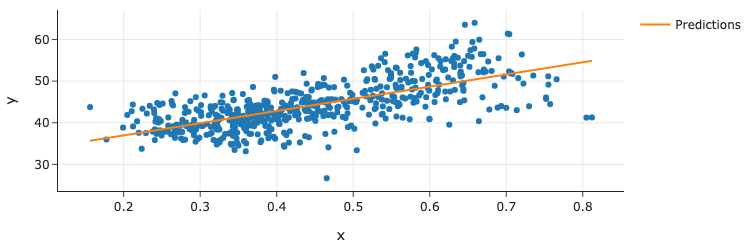

In [33]:
fig = px.scatter(x=x_train, y=y_train,
                 width=450, height=250)

pred_x = np.array([x.min(), x.max()])
pred_y = t0 + t1 * pred_x

fig.add_trace(go.Scatter(x=pred_x, y=pred_y, name='Predictions', mode='lines'))
fig

We can see that the line has a positive slope, which captures the
positive association between AUM 
and the fraction of people with ≤15 min commute.

To check the model fit, we use a *residual plot*, which puts the
predicted $ f_{\theta}(x) $ values on the x-axis and the residuals
$ y - f_{\theta}(x) $ on the y-axis:

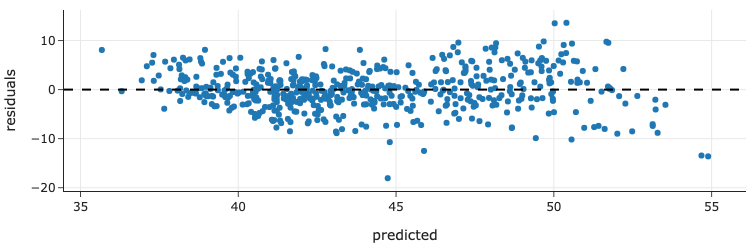

In [34]:
predicted = t0 + t1 * x_train
resid = pd.DataFrame({'predicted': predicted,
                      'residuals': y_train - predicted})
fig = px.scatter(resid, x='predicted', y='residuals',
                 width=350, height=250)

fig.add_hline(0, line_color='black', line_width=2, line_dash='dash', opacity=1)

Residual plots can show problems with using a linear model.
A good fit will show a residual plot with a
cloud of points around the y=0 line with no clear pattern.
When there is a clear pattern, we can usually conclude that a linear model
wasn't a good choice for the data.

In the plot above, the model doesn't actually have a good fit---there's a
small but clear curve in the residual plot.
This tells us that we should look at other predictor variables, or include
other variables into our model.

The residual plot can also give us a general sense of how accurate
the model is.
Most of the residuals lie between +10 and -10 AUM.
But 10 AUM is a lot of error---it's bigger than the gap between the
25th percentile and the 75th percentile AUM.

In this section, we derived the model parameters
$ \hat{\theta}_0 $ and $ \hat{\theta}_1 $ using calculus.
Then, we fit a simple linear model that predicts AUM for a commuting zone
using the fraction of people with a ≤15 min commute.
A residual plot shows that this linear model doesn't fit the data well.
But we didn't expect a great fit to begin with---economic
mobility is a complicated metric that
probably can't be predicted using a single variable.
To improve our model's accuracy, we can use
multiple predictor variables rather than just one.
This model is called a multiple linear model, and we'll introduce this model
in the next section.